In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ReLU Activation Function
def relu(x):
    return np.maximum(0, x)

# Derivative of ReLU (for backpropagation)
def relu_derivative(x):
    return np.where(x > 0, 1, 0)

# Softmax Activation Function
def softmax(x):
    exp_values = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_values / np.sum(exp_values, axis=1, keepdims=True)

# Cross-Entropy Loss Function
def cross_entropy_loss(y_pred, y_true):
    n_samples = y_true.shape[0]
    log_p = -np.log(y_pred[range(n_samples), y_true])
    loss = np.sum(log_p) / n_samples
    return loss

# Derivative of Cross-Entropy Loss wrt Softmax Output
def cross_entropy_derivative(y_pred, y_true):
    n_samples = y_true.shape[0]
    grad = y_pred.copy()
    grad[range(n_samples), y_true] -= 1
    grad = grad / n_samples
    return grad

# Accuracy calculation
def accuracy(y_pred, y_true):
    predictions = np.argmax(y_pred, axis=1)
    return np.mean(predictions == y_true)

class NeuralNetwork:
    def __init__(self, input_size, hidden1_size, hidden2_size, output_size, beta=0.9):
        # Initialize weights with He initialization
        self.W1 = np.random.randn(input_size, hidden1_size) * np.sqrt(2. / input_size)
        self.b1 = np.zeros((1, hidden1_size))
        self.W2 = np.random.randn(hidden1_size, hidden2_size) * np.sqrt(2. / hidden1_size)
        self.b2 = np.zeros((1, hidden2_size))
        self.W3 = np.random.randn(hidden2_size, output_size) * np.sqrt(2. / hidden2_size)
        self.b3 = np.zeros((1, output_size))

        # Initialize velocity terms for momentum
        self.vW1 = np.zeros_like(self.W1)
        self.vb1 = np.zeros_like(self.b1)
        self.vW2 = np.zeros_like(self.W2)
        self.vb2 = np.zeros_like(self.b2)
        self.vW3 = np.zeros_like(self.W3)
        self.vb3 = np.zeros_like(self.b3)

        self.beta = beta

    def forward(self, X):
        # Forward pass
        self.Z1 = np.dot(X, self.W1) + self.b1
        self.A1 = relu(self.Z1)

        self.Z2 = np.dot(self.A1, self.W2) + self.b2
        self.A2 = relu(self.Z2)

        self.Z3 = np.dot(self.A2, self.W3) + self.b3
        self.A3 = softmax(self.Z3)

        return self.A3

    def backprop(self, X, y, output):
        # Backpropagation to compute gradients
        m = y.shape[0]

        # Output layer gradient (Softmax + Cross-Entropy)
        dZ3 = cross_entropy_derivative(output, y)
        dW3 = np.dot(self.A2.T, dZ3)
        db3 = np.sum(dZ3, axis=0, keepdims=True)

        # Second hidden layer gradient
        dA2 = np.dot(dZ3, self.W3.T)
        dZ2 = dA2 * relu_derivative(self.Z2)
        dW2 = np.dot(self.A1.T, dZ2)
        db2 = np.sum(dZ2, axis=0, keepdims=True)

        # First hidden layer gradient
        dA1 = np.dot(dZ2, self.W2.T)
        dZ1 = dA1 * relu_derivative(self.Z1)
        dW1 = np.dot(X.T, dZ1)
        db1 = np.sum(dZ1, axis=0, keepdims=True)

        # Return gradients
        return dW1, db1, dW2, db2, dW3, db3

    def update_parameters(self, dW1, db1, dW2, db2, dW3, db3, learning_rate):
        # Momentum update
        self.vW1 = self.beta * self.vW1 + (1 - self.beta) * dW1
        self.vb1 = self.beta * self.vb1 + (1 - self.beta) * db1
        self.vW2 = self.beta * self.vW2 + (1 - self.beta) * dW2
        self.vb2 = self.beta * self.vb2 + (1 - self.beta) * db2
        self.vW3 = self.beta * self.vW3 + (1 - self.beta) * dW3
        self.vb3 = self.beta * self.vb3 + (1 - self.beta) * db3

        # Gradient descent step with momentum
        self.W1 -= learning_rate * self.vW1
        self.b1 -= learning_rate * self.vb1
        self.W2 -= learning_rate * self.vW2
        self.b2 -= learning_rate * self.vb2
        self.W3 -= learning_rate * self.vW3
        self.b3 -= learning_rate * self.vb3

def train(X_train, y_train, X_test, y_test, nn, epochs, learning_rate, batch_size=32):
    m = X_train.shape[0]

    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(epochs):
        indices = np.random.permutation(m)  # Shuffle the data
        X_shuffled = X_train[indices]
        y_shuffled = y_train[indices]

        for i in range(0, m, batch_size):
            X_batch = X_shuffled[i:i + batch_size]
            y_batch = y_shuffled[i:i + batch_size]

            # Forward pass
            output = nn.forward(X_batch)

            # Compute training loss
            loss = cross_entropy_loss(output, y_batch)

            # Backpropagation
            dW1, db1, dW2, db2, dW3, db3 = nn.backprop(X_batch, y_batch, output)

            # Update parameters
            nn.update_parameters(dW1, db1, dW2, db2, dW3, db3, learning_rate)

        # At the end of each epoch, evaluate on the entire training and test sets
        train_output = nn.forward(X_train)
        train_loss = cross_entropy_loss(train_output, y_train)
        train_accuracy = accuracy(train_output, y_train)

        test_output = nn.forward(X_test)
        test_loss = cross_entropy_loss(test_output, y_test)
        test_accuracy = accuracy(test_output, y_test)

        # Store the losses and accuracies
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)

        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss}, Test Loss: {test_loss}, '
                f'Train Accuracy: {train_accuracy}, Test Accuracy: {test_accuracy}')

    return train_losses, test_losses, train_accuracies, test_accuracies

# Load the CSV data
x_train = pd.read_csv('Task_2/x_train.csv').values
y_train = pd.read_csv('Task_2/y_train.csv').values.flatten()
x_test = pd.read_csv('Task_2/x_test.csv').values
y_test = pd.read_csv('Task_2/y_test.csv').values.flatten()

input_size = x_train.shape[1]
hidden1_size = 100
hidden2_size = 40
output_size = 4 
epochs = 100

# Learning rates to test
learning_rates = [1, 0.1, 0.01, 0.001]
train_losses = {}
test_losses = {}
train_accuracies = {}
test_accuracies = {}

for lr in learning_rates:
    print(f'Training with learning rate: {lr}')
    nn = NeuralNetwork(input_size, hidden1_size, hidden2_size, output_size)
    tr_loss, te_loss, tr_acc, te_acc = train(x_train, y_train, x_test, y_test, nn, epochs, lr)

    train_losses[lr] = tr_loss
    test_losses[lr] = te_loss
    train_accuracies[lr] = tr_acc
    test_accuracies[lr] = te_acc

Training with learning rate: 1
Epoch 10/100, Train Loss: 0.5642274330712679, Test Loss: 0.6192082794804414, Train Accuracy: 0.7981840378452617, Test Accuracy: 0.7905982905982906
Epoch 20/100, Train Loss: 0.8087461750767081, Test Loss: 0.8582111279887218, Train Accuracy: 0.729131695406684, Test Accuracy: 0.7268009768009768
Epoch 30/100, Train Loss: 0.7241914466177631, Test Loss: 0.8461201385085662, Train Accuracy: 0.6881580955287655, Test Accuracy: 0.6688034188034188


c:\Users\sajee\miniconda3\envs\dnn-assignment\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log


Epoch 40/100, Train Loss: 1.924058885958792, Test Loss: inf, Train Accuracy: 0.431100259423165, Test Accuracy: 0.4001831501831502
Epoch 50/100, Train Loss: 1.3434410532387124, Test Loss: 1.352650954365313, Train Accuracy: 0.2767434762704105, Test Accuracy: 0.2619047619047619
Epoch 60/100, Train Loss: 1.3805901652707944, Test Loss: 1.461668738960779, Train Accuracy: 0.27643827254692505, Test Accuracy: 0.2793040293040293
Epoch 70/100, Train Loss: 1.3662917895957811, Test Loss: 1.3677934583878997, Train Accuracy: 0.29421638943995115, Test Accuracy: 0.2960927960927961
Epoch 80/100, Train Loss: 1.3809773551655946, Test Loss: 1.3801234296177314, Train Accuracy: 0.2855180833206165, Test Accuracy: 0.2890720390720391
Epoch 90/100, Train Loss: 1.403674791555497, Test Loss: 1.4000852976909992, Train Accuracy: 0.2760567678925683, Test Accuracy: 0.2780830280830281
Epoch 100/100, Train Loss: 1.3856596583646066, Test Loss: 1.3879396558623684, Train Accuracy: 0.2760567678925683, Test Accuracy: 0.27808

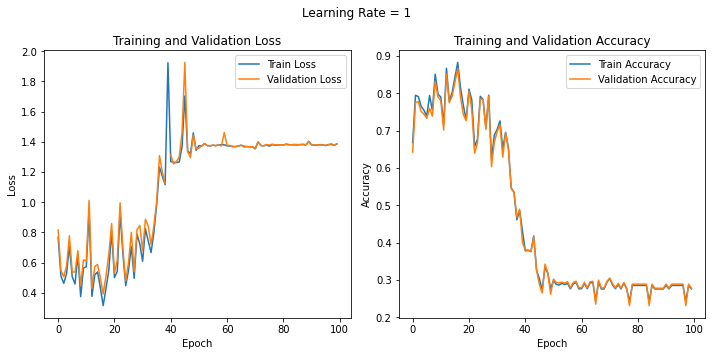

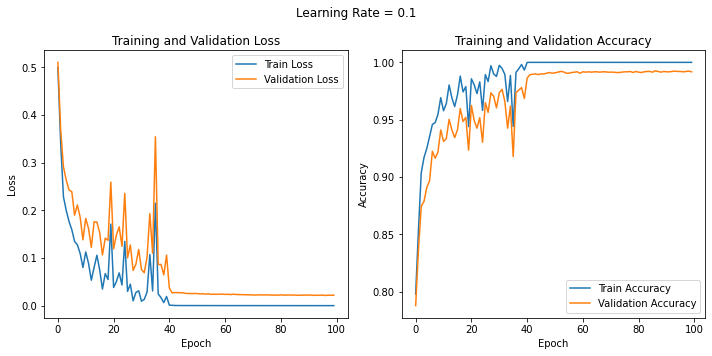

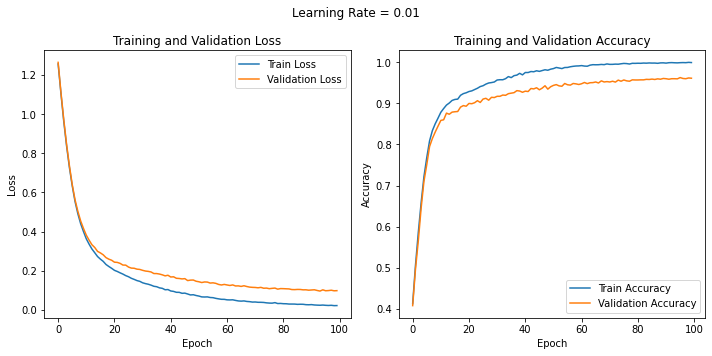

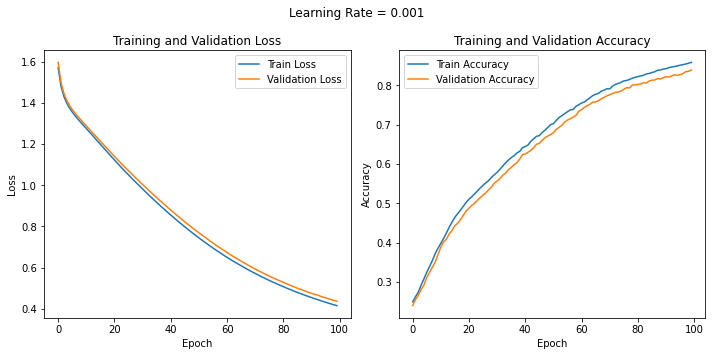

In [4]:
import matplotlib.pyplot as plt

learning_rates = [1, 0.1, 0.01,0.001]
epochs_range = range(epochs)

for lr in learning_rates:

    # Plot the loss curves
    plt.figure(figsize=(10, 5))
    plt.suptitle(f"Learning Rate = {lr}")
    plt.subplot(1, 2, 1)
    plt.plot(train_losses[lr], label="Train Loss")
    plt.plot(test_losses[lr], label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()

    # Plot the accuracy curves
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies[lr], label="Train Accuracy")
    plt.plot(test_accuracies[lr], label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training and Validation Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()